In [3]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_validate, ShuffleSplit, train_test_split
import pandas as pd
import data_pecarn 
import data_psrc
import data
from collections import Counter
plt.style.use('dark_background')
# sns.set(style="white")
%matplotlib inline
%load_ext autoreload
%autoreload 2
NUM_PATIENTS = 12044

**load the data**

In [5]:
dummy = False
df_pecarn = data_pecarn.get_data(use_processed=False,
                                 frac_missing_allowed=0.1,
                                 dummy=dummy)
all_feats_pecarn, filtered_feats_pecarn = data.get_feat_names(df_pecarn)
df_psrc = data_psrc.get_data(use_processed=False, dummy=dummy)
all_feats_psrc, filtered_feats_psrc = data.get_feat_names(df_psrc)

# resulting features
outcome_def = 'iai_intervention' # output
meta = [outcome_def, 'cv_fold', 'dset']
common_feats = list(filtered_feats_pecarn.intersection(filtered_feats_psrc))
common_feats = common_feats + meta
feats_numerical = ['InitSysBPRange', 'InitHeartRate', 'GCSScore', 'Age']
feats_categorical = ['AbdTenderDegree', 'Race', 'RecodedMOI']
feats_binary = [feat for feat in common_feats
                     if not feat in feats_numerical + feats_categorical + meta]

computing pecarn preprocessing...
computing psrc preprocessing...


In [10]:
print('num features', len(common_feats) - len(meta))

num features 20


In [8]:
for feat in common_feats:
    print(feat, '\t', df_pecarn[feat].min(), '\t', df_pecarn[feat].max())

AbdDistention 	 no 	 yes
Age 	 0 	 17
AbdomenPain 	 no 	 yes
DecrBreathSound 	 no 	 yes
VomitWretch 	 no 	 yes
LtCostalTender 	 1.0 	 4.0
AbdTrauma_or_SeatBeltSign 	 no 	 yes
Hypotension 	 False 	 True
DistractingPain 	 no 	 yes
InitHeartRate 	 0.0 	 268.0
AbdTenderDegree 	 Mild 	 unknown
InitSysBPRange 	 36.0 	 202.0
GCSScore 	 3.0 	 15.0
SeatBeltSign 	 no 	 yes
AbdTrauma 	 no 	 yes
RtCostalTender 	 1.0 	 4.0
CostalTender 	 False 	 True
ThoracicTrauma 	 no 	 yes
Race 	 American Indian or Alaska Native 	 unknown
RecodedMOI 	 Bike collision/fall 	 unknown
iai_intervention 	 0 	 1
cv_fold 	 1 	 6
dset 	 pecarn 	 pecarn


**look at resulting feats**

In [ ]:
filtered_feats_pecarn.intersection(filtered_feats_psrc)

In [17]:
print('psrc but not pecarn')
filtered_feats_psrc.difference(filtered_feats_pecarn)

psrc but not pecarn


{'FemurFracture'}

In [18]:
print('pecarn but not psrc')
print(filtered_feats_pecarn.difference(filtered_feats_psrc))

pecarn but not psrc
{'ThoracicTender'}


# look for feat shift

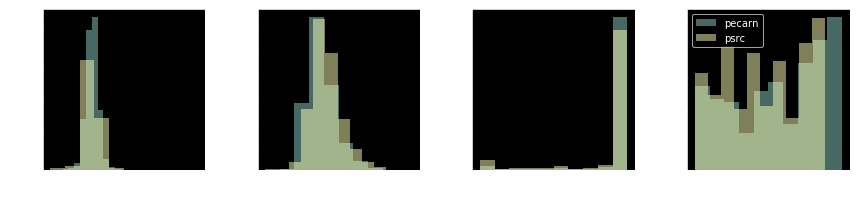

In [45]:
R, C, = 1, 4
plt.figure(figsize=(12, 3))
for i in range(len(feats_numerical)):
    plt.subplot(R, C, i + 1)
    feat = feats_numerical[i]
    plt.hist(df_pecarn[feat], density=True, alpha=0.5, label='pecarn')
    plt.hist(df_psrc[feat], density=True, alpha=0.5, label='psrc')
    plt.xlabel(feat)
plt.legend()
plt.tight_layout()
plt.show()

/accounts/projects/vision/.local/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  # This is added back by InteractiveShellApp.init_path()


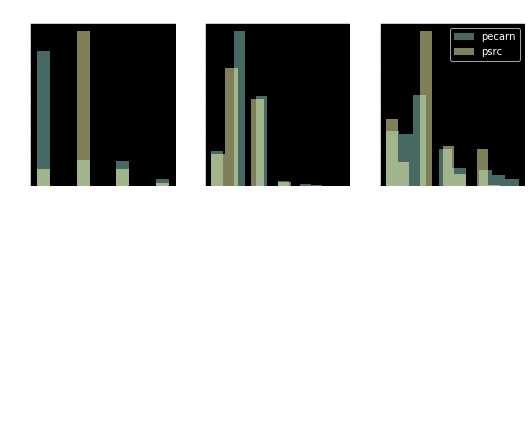

In [46]:
R, C, = 1, 4
plt.figure(figsize=(12, 3))
for i in range(len(feats_categorical)):
    plt.subplot(R, C, i + 1)
    feat = feats_categorical[i]
    plt.hist(df_pecarn[feat], density=True,alpha=0.5, label='pecarn')
    plt.hist(df_psrc[feat], density=True, alpha=0.5, label='psrc')
    plt.xticks(rotation='vertical')
    plt.title(feat)
plt.legend()
plt.tight_layout()
plt.show()

/accounts/projects/vision/.local/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


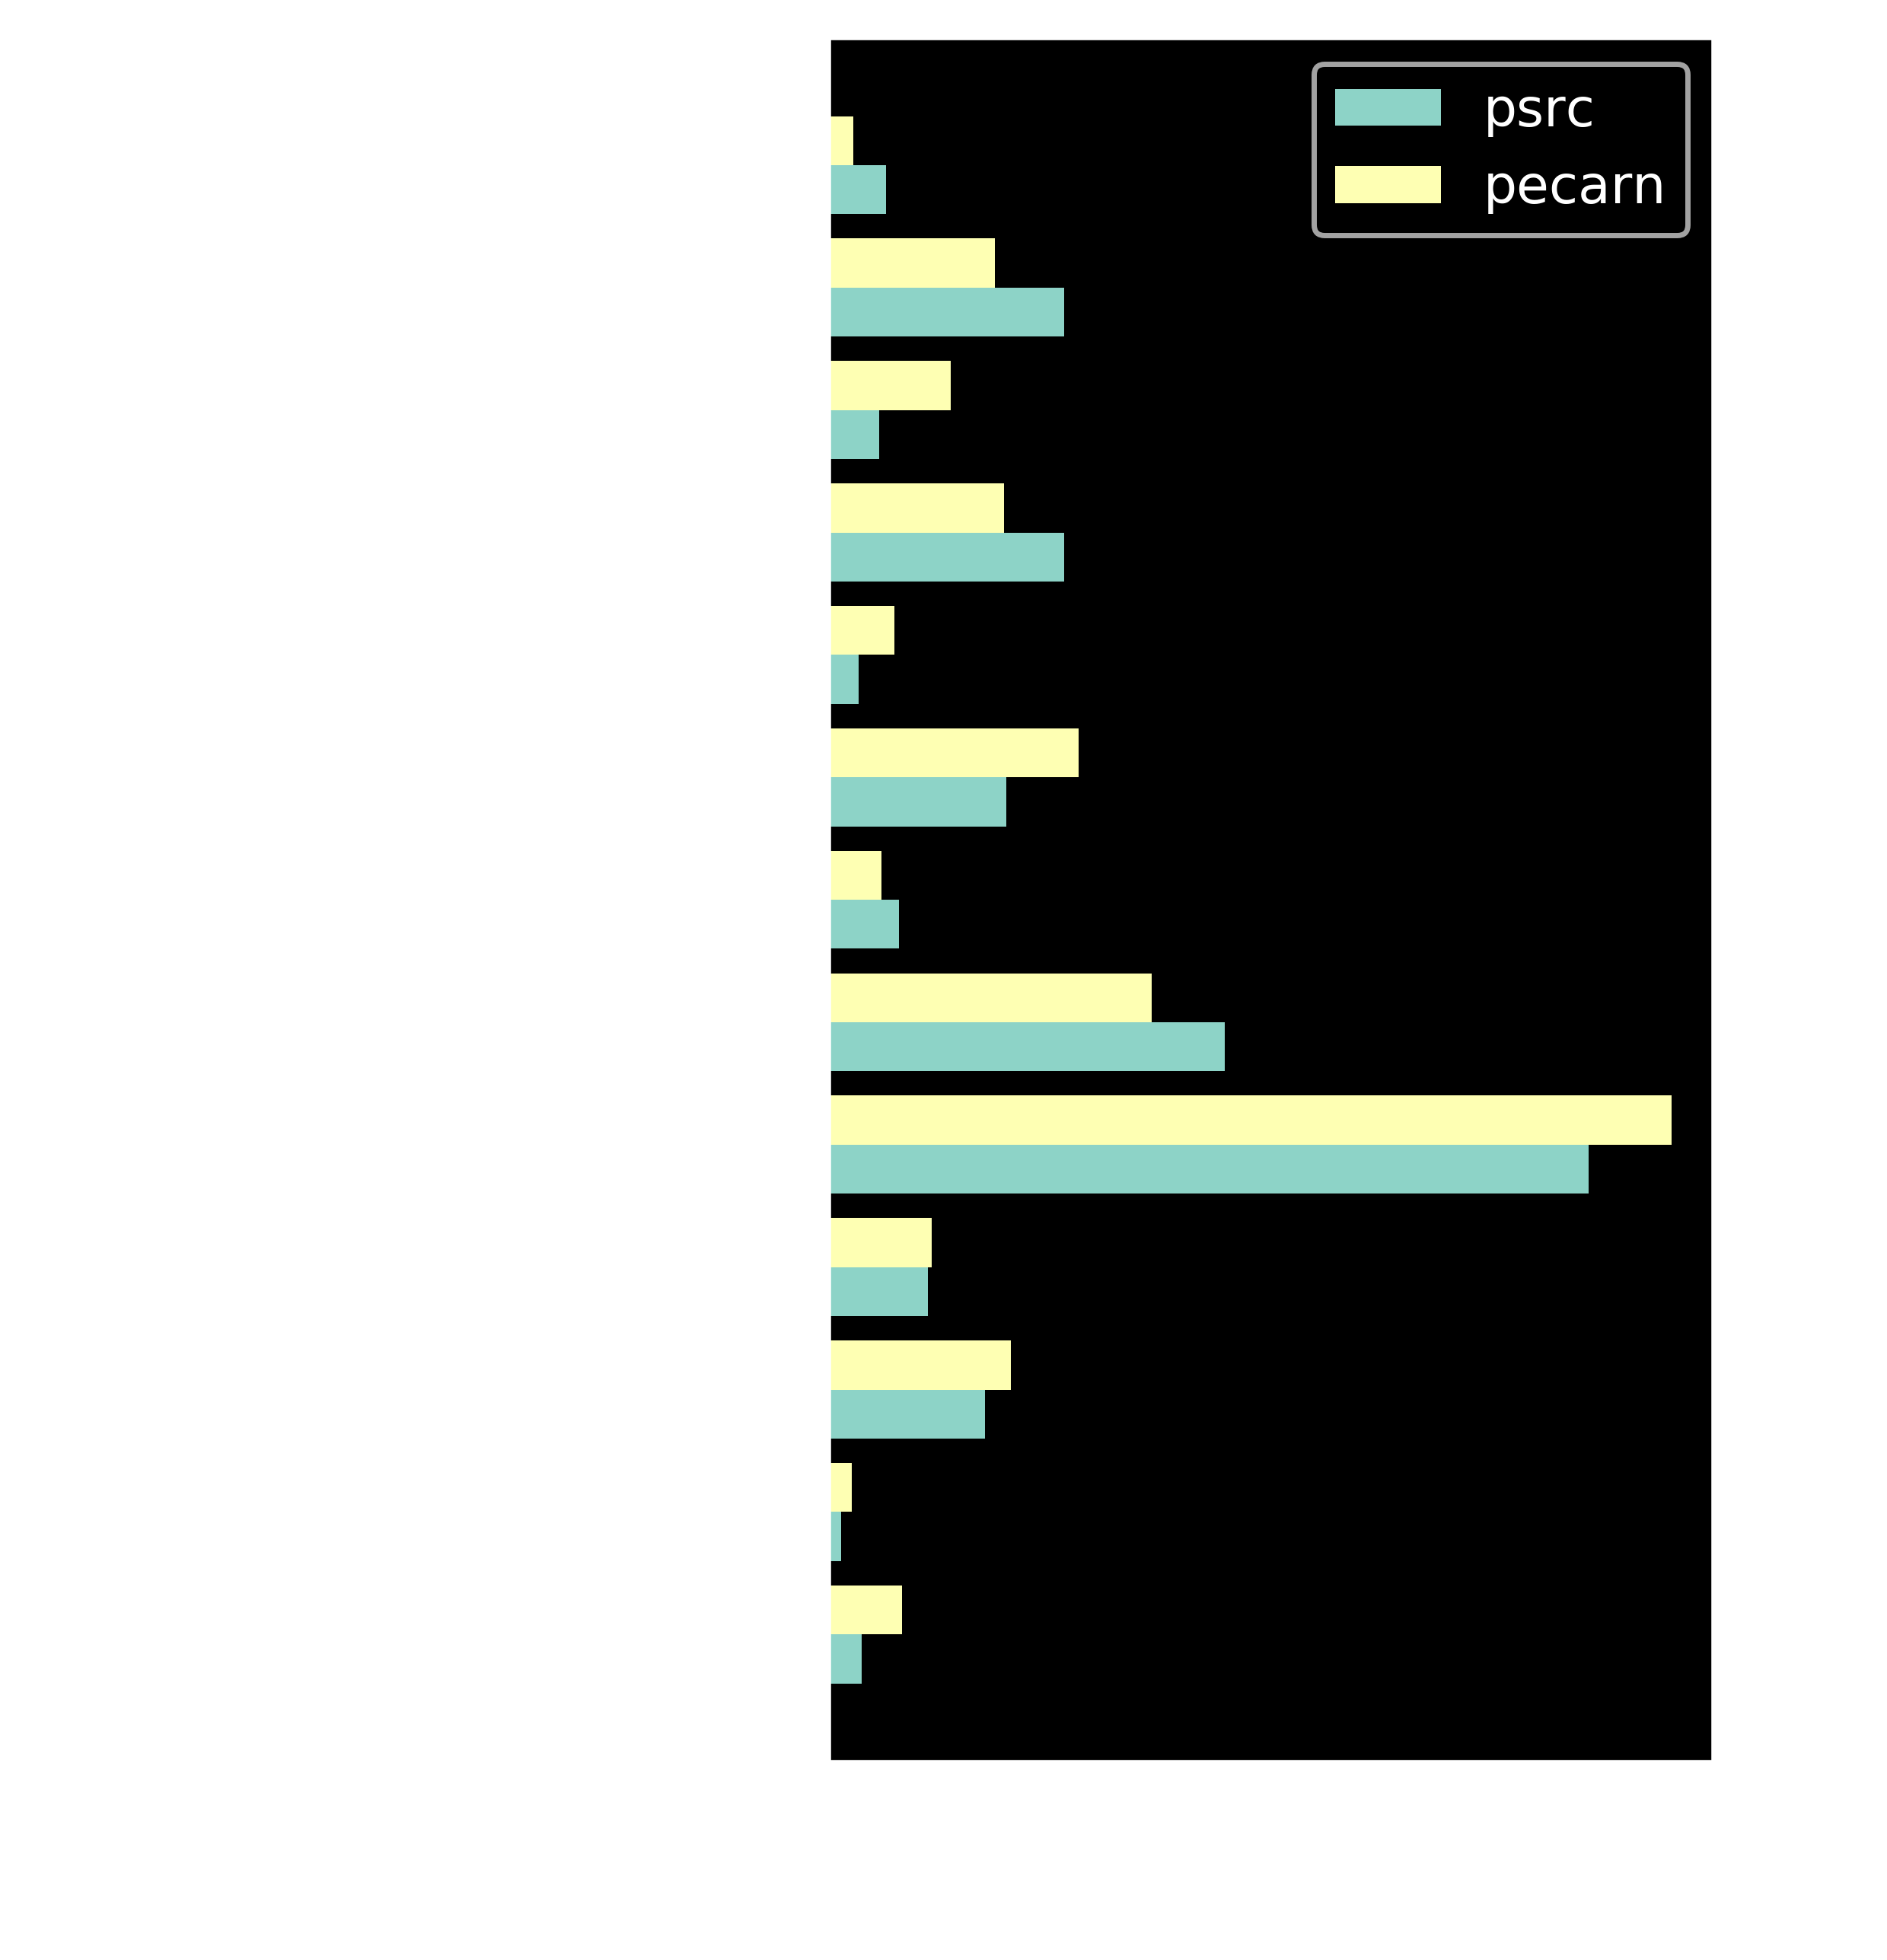

In [49]:
R, C = 3, 4
n = len(feats_binary)
def true_or_yes(vals):
    return (vals==True) | (vals=='yes')
frac_psrc = true_or_yes(df_psrc[feats_binary]).mean().values
frac_pecarn = true_or_yes(df_pecarn[feats_binary]).mean().values

width = 0.4
plt.figure(dpi=500, figsize=(3, 6))
plt.barh(np.arange(n) - width, frac_psrc, height=0.4, label='psrc')
plt.barh(np.arange(n), frac_pecarn, height=0.4, label='pecarn')
plt.yticks(np.arange(n) - width + 0.2, feats_binary)
plt.xlabel('fraction of patients for which this is present')
plt.legend()
plt.show()

**missing features**

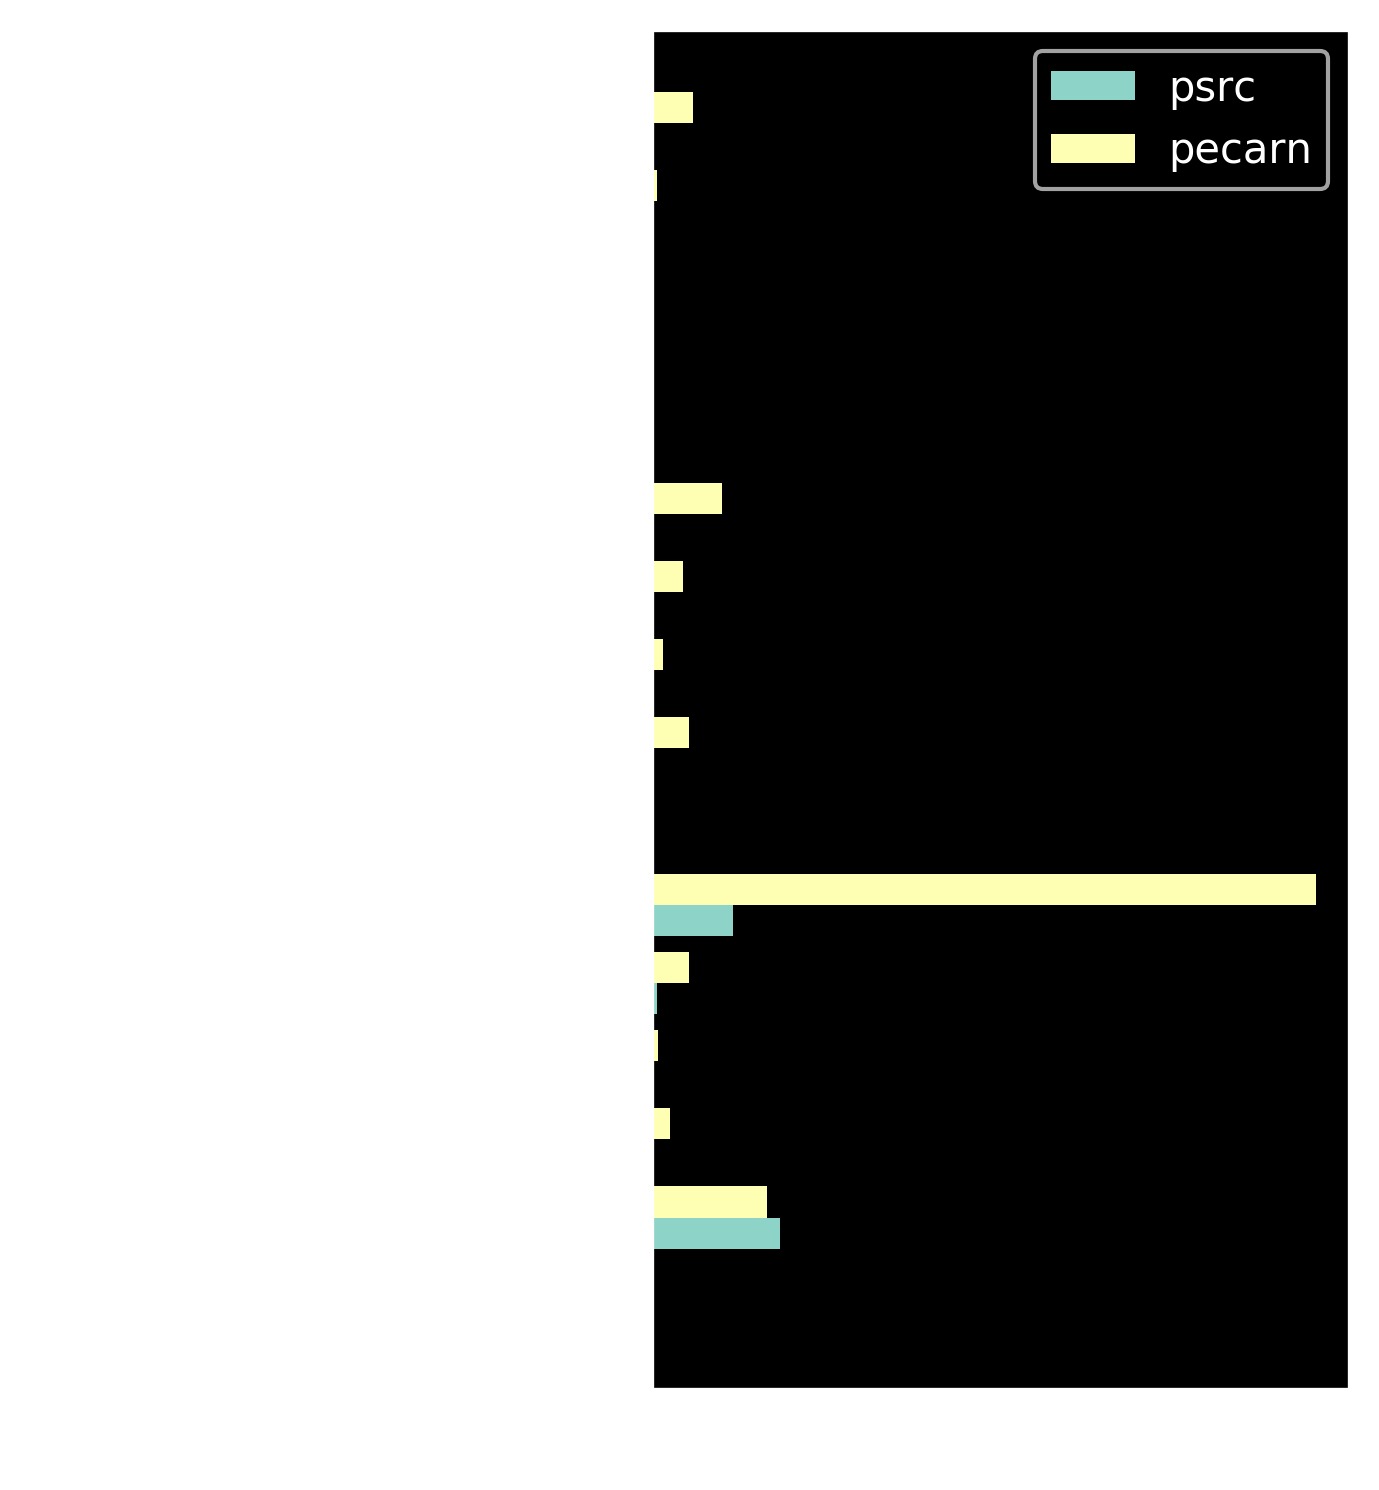

In [50]:
R, C = 3, 4
feats_categorical = [feat for feat in common_feats
                     if not feat in feats_numerical and not feat in ['dset', 'cv_fold', 'iai_intervention']]
n = len(feats_categorical)
frac_psrc = (df_psrc[feats_categorical]=='unknown').mean().values
frac_pecarn = (df_pecarn[feats_categorical]=='unknown').mean().values

width = 0.4
plt.figure(dpi=300, figsize=(3, 6))
plt.barh(np.arange(n) - width, frac_psrc, height=0.4, label='psrc')
plt.barh(np.arange(n), frac_pecarn, height=0.4, label='pecarn')
plt.yticks(np.arange(n) - width + 0.2, feats_categorical)

plt.legend()
plt.show()

# write csvs

In [23]:
df_pecarn.astype('object').describe().transpose().to_csv('processed/pecarn_vars.csv')
df_psrc.astype('object').describe().transpose().to_csv('processed/psrc_vars.csv')

In [117]:
common_feats = [x for x in feat_names_pecarn if x in feat_names_psrc]

In [17]:
df_psrc['Emesis post injury'].unique()

array([ 0., nan,  1.])